# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, the goal is to compare the performance of the following classifiers: Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines. The target dataset is related to marketing bank products over the telephone.  



### Getting Started

The dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

A: The dataset is about 17 campaigns between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

In [87]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn import set_config

set_config(display="diagram")

In [3]:
full_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
full_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



The following function and subsequent calls to specific columns is to test whether the unknown answers have some relationship to the target column, in order to decide whether to impute, delete or keep the unknown values. All known features are grouped into a 'known' column to be compared against the unknown. The ratios are given by the cross-table and after that the features are tested using a chi2 test. If the p_value is below a certain threshold (0.01) we can say that the variable is related to the target.

In [5]:
def test_unknown_values(X, y, column):
    df_to_test = X[[column]].copy()
    df_to_test[column] = np.where(df_to_test[column] == 'unknown', 'unknown', 'known')

    crosstab = pd.crosstab(df_to_test[column], y, margins=True)
    crosstab["Ratio"] = crosstab["yes"] / crosstab["All"]

    test_transformer = make_column_transformer(
        (OneHotEncoder(sparse_output=False), [column]), verbose_feature_names_out=False
    ).fit(df_to_test)
    test_df = pd.DataFrame(
        test_transformer.transform(df_to_test),
        columns=test_transformer.get_feature_names_out(),
    )
    chi2_stats, p_values = chi2(test_df, y)
    chi2_df = pd.DataFrame(
        [chi2_stats, p_values],
        columns=test_transformer.get_feature_names_out(),
        index=["chi2", "p_value"],
    ).T

    print(f"Column: {column}")
    display(crosstab)
    display(chi2_df)

In [6]:
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'housing')
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'default')
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'marital')
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'job')
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'education')
test_unknown_values(full_df.drop(['y'], axis=1), full_df['y'], 'loan')

Column: housing


y,no,yes,All,Ratio
housing,,,,
known,35665,4533,40198,0.112767
unknown,883,107,990,0.108081
All,36548,4640,41188,0.112654


,chi2,p_value
housing_known,0.005101,0.943060
housing_unknown,0.207141,0.649017


Column: default


y,no,yes,All,Ratio
default,,,,
known,28394,4197,32591,0.128778
unknown,8154,443,8597,0.051530
All,36548,4640,41188,0.112654


,chi2,p_value
default_known,84.759343,3.369830e-20
default_unknown,321.320431,7.469382e-72


Column: marital


y,no,yes,All,Ratio
marital,,,,
known,36480,4628,41108,0.112581
unknown,68,12,80,0.150000
All,36548,4640,41188,0.112654


,chi2,p_value
marital_known,0.002172,0.962827
marital_unknown,1.116179,0.290743


Column: job


y,no,yes,All,Ratio
job,,,,
known,36255,4603,40858,0.112658
unknown,293,37,330,0.112121
All,36548,4640,41188,0.112654


,chi2,p_value
job_known,0.000008,0.997804
job_unknown,0.000938,0.975571


Column: education


y,no,yes,All,Ratio
education,,,,
known,35068,4389,39457,0.111235
unknown,1480,251,1731,0.145003
All,36548,4640,41188,0.112654


,chi2,p_value
education_known,0.794958,0.372605
education_unknown,18.120535,0.000021


Column: loan


y,no,yes,All,Ratio
loan,,,,
known,35665,4533,40198,0.112767
unknown,883,107,990,0.108081
All,36548,4640,41188,0.112654


,chi2,p_value
loan_known,0.005101,0.943060
loan_unknown,0.207141,0.649017


In [7]:
df = full_df.copy()

# The data description says that the 'duration' column is directly related
# to the output target 'y', so I am dropping it.
df = df.drop(["duration"], axis=1)

# Imputations: education and housing
imp_education = SimpleImputer(missing_values='unknown', strategy='most_frequent').fit_transform(df[['education']])
imp_housing = SimpleImputer(missing_values='unknown', strategy='most_frequent').fit_transform(df[['housing']])
df['education'] = [x[0] for x in imp_education]
df['housing'] = [x[0] for x in imp_housing]

# The 'default' feature has 32588 'no', 8597 'unknown', and only 3 'yes'.
# The test showed that the unknown values are related to the target column,
# so these unknown values cannot be dropped.

# The marital/job/loan features have unknown values but the test above showed
# that they are not related to the target column, so I am dropping these rows.
df = df[df.marital != 'unknown']
df = df[df.job != 'unknown']
df = df[df.loan != 'unknown']

# pdays is the number of days the client was last contacted since a previous
# campaign. 999 is 'never', so to better model this I am binning the values
# into four ranges: within 1 week, within 2 weeks, within 4 weeks, and never
df.pdays = pd.cut(
    df.pdays,
    bins=[-0.01, 3, 14, 30, 1000],
    labels=[
        "within_3_days",
        "within_2_weeks",
        "within_4_weeks",
        "never",
    ],
    retbins=False,
).astype("object")

# Resetting the index
df = df.reset_index(drop=True)

# Encoding housing, loan, and target yes/no values into 1/0
df.housing = df.housing.map({'yes': 1, 'no': 0})
df.loan = df.loan.map({'yes': 1, 'no': 0})
df.y = df.y.map({'yes': 1, 'no': 0})

# Prints value_counts for all categorical features
# for i in df.select_dtypes(include="object"):
#     print(df[i].value_counts())
#     print("")

df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
16003,31,technician,married,basic.9y,no,1,0,cellular,jul,wed,1,never,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0
12029,24,services,married,high.school,no,1,0,cellular,jul,mon,4,never,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,0
33005,30,technician,single,high.school,no,1,0,cellular,may,wed,3,never,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1,0
10208,31,blue-collar,married,basic.9y,unknown,1,0,telephone,jun,tue,3,never,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,1
616,32,housemaid,married,high.school,no,0,0,telephone,may,tue,1,never,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

A: Marketing campaigns are important to companies such as banks, but sometimes they can be a nuisance to the customers if done poorly or to uninterested customers. The business goal around this dataset analysis is to find a model that can predict the success of a campaign given a set of features about the people that are contacted. If done correctly, the model can increase campaign efficiency which in turn will help the company to better use their resources and also target people that are really potential customers.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [43]:
df_features = df.drop('y', axis = 1)
df_features = df_features[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'campaign', 'pdays', 'previous', 'poutcome']]
df_target = df['y'].copy()

features_column_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=object)),
    remainder = StandardScaler(), verbose_feature_names_out=False,
).fit(df_features)

X = pd.DataFrame(features_column_transformer.transform(df_features), columns = features_column_transformer.get_feature_names_out())
y = df_target.copy()

In [44]:
X.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,pdays_within_3_days,pdays_within_4_weeks,poutcome_failure,poutcome_nonexistent,poutcome_success,age,housing,loan,campaign,previous
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.539987,-1.077050,-0.428845,-0.566762,-0.349299
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.636117,-1.077050,-0.428845,-0.566762,-0.349299
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-0.286490,0.928462,-0.428845,-0.566762,-0.349299
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.001901,-1.077050,-0.428845,-0.566762,-0.349299
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.539987,-1.077050,2.331843,-0.566762,-0.349299


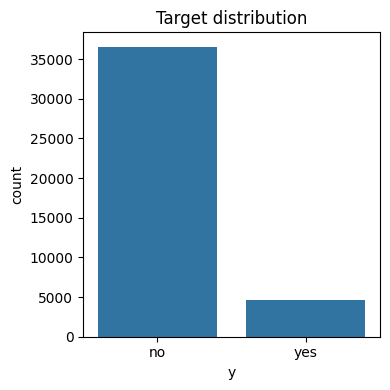

y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

In [45]:
f, ax = plt.subplots(figsize=(4,4))

sns.countplot(data = full_df, x = 'y', ax=ax)
plt.title('Target distribution')

plt.tight_layout()
plt.show()

display(full_df['y'].value_counts(normalize=True))

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Baseline Model

In [65]:
model_dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

print(f'Baseline accuracy for training data: {model_dummy.score(X_train, y_train)}')
print(f'Baseline accuracy for testing data: {model_dummy.score(X_test, y_test)}')

Baseline accuracy for training data: 0.887255825639093
Baseline accuracy for testing data: 0.8873257128501445


This accuracy is expected since the target is 88.7% no and 11.3% yes.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [66]:
simple_lreg = LogisticRegression(max_iter=5000).fit(X_train, y_train)

### Problem 9: Score the Model

What is the accuracy of your model?

In [67]:
print(f'Accuracy of simple Logistic Regression model')
print(f'... on training data: {accuracy_score(y_train, simple_lreg.predict(X_train))}')
print(f'... on test data: {accuracy_score(y_test, simple_lreg.predict(X_test))}')
print(f'Precision of simple Logistic Regression model')
print(f'... on training data: {metrics.precision_score(y_train, simple_lreg.predict(X_train))}')
print(f'... on test data: {metrics.precision_score(y_test, simple_lreg.predict(X_test))}')

Accuracy of simple Logistic Regression model
... on training data: 0.8972426355128447
... on test data: 0.8988820499937193
Precision of simple Logistic Regression model
... on training data: 0.658051689860835
... on test data: 0.6796875


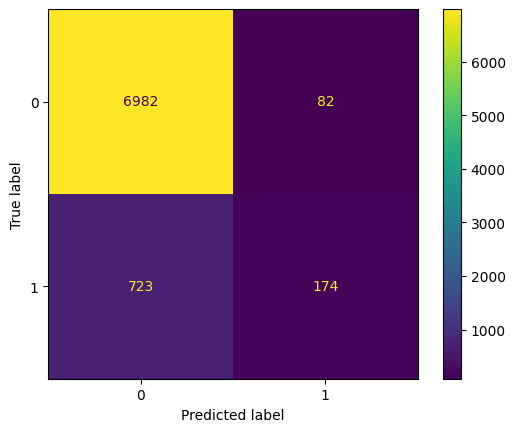

In [68]:
ConfusionMatrixDisplay.from_estimator(simple_lreg, X_test, y_test, values_format='d')
plt.show()

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [69]:
test_models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
}

test_models_output = {}
for model_name, model in test_models.items():
    test_models_output[model_name] = {}
    
    start_time = time.time()
    test_models_output[model_name]['model'] = model.fit(X_train, y_train)
    test_models_output[model_name]['train_time'] = time.time() - start_time
    test_models_output[model_name]['train_accuracy'] = accuracy_score(y_train, test_models_output[model_name]['model'].predict(X_train))
    test_models_output[model_name]['test_accuracy'] = accuracy_score(y_test, test_models_output[model_name]['model'].predict(X_test))


In [70]:
# KNN
print(f'KNN number_of_neighbors: {test_models["KNN"].n_neighbors}')

# Decision Tree
print(f'Decision Tree max_depth: {test_models["Decision Tree"].tree_.max_depth}')

KNN number_of_neighbors: 5
Decision Tree max_depth: 39


In [71]:
test_models_df = pd.DataFrame({
    'Model': list(test_models_output.keys()),
    'Train Time': [test_models_output[model_name]['train_time'] for model_name in test_models_output.keys()],
    'Train Accuracy': [test_models_output[model_name]['train_accuracy'] for model_name in test_models_output.keys()],
    'Test Accuracy': [test_models_output[model_name]['test_accuracy'] for model_name in test_models_output.keys()],
}).set_index('Model')

test_models_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
KNN,0.003651,0.905471,0.888959
Decision Tree,0.130518,0.964167,0.843361
SVM,87.008188,0.899567,0.898505


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Performance metric

I have chosen recall as the main performance metric since I want to maximize the number of true positives. I will also track the precision in order to track the false positives, since the less false positives we have, the less time we will spend with people that will probably not subscribe to term deposit.

#### Logistic Regression

In [72]:
grid_logreg = GridSearchCV(
    LogisticRegression(max_iter=5000, class_weight="balanced"),
    param_grid={
        "C": 10.0 ** np.array([-3, -2, -1, 0]),
    },
    scoring="recall",
    n_jobs=-1,
).fit(X_train, y_train)

print("Best params:")
grid_logreg.best_params_

Best params:


{'C': 0.01}

In [73]:
print("Logistic Regression")
print("** accuracy score:")
print(f"... on training data: {metrics.accuracy_score(y_train, grid_logreg.predict(X_train))}")
print(f"... on test data: {metrics.accuracy_score(y_test, grid_logreg.predict(X_test))}")
print("** recall score:")
print(f"... on training data: {metrics.recall_score(y_train, grid_logreg.predict(X_train))}")
print(f"... on test data: {metrics.recall_score(y_test, grid_logreg.predict(X_test))}")
print("** precision score:")
print(f"... on training data: {metrics.precision_score(y_train, grid_logreg.predict(X_train))}")
print(f"... on test data: {metrics.precision_score(y_test, grid_logreg.predict(X_test))}")


Logistic Regression
** accuracy score:
... on training data: 0.6756171094780479
... on test data: 0.6801909307875895
** recall score:
... on training data: 0.6462395543175488
... on test data: 0.6465997770345596
** precision score:
... on training data: 0.2038843483610159
... on test data: 0.20647917408330366


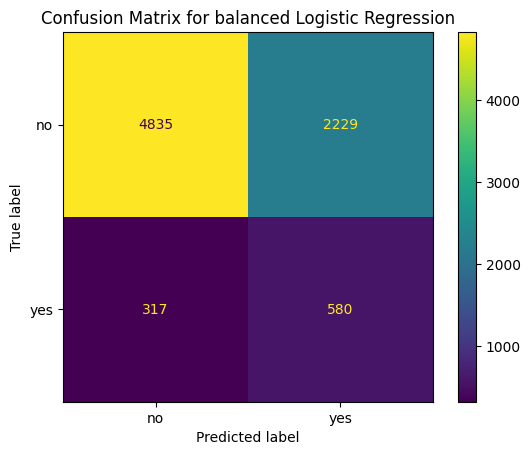

In [74]:
ConfusionMatrixDisplay.from_estimator(grid_logreg.best_estimator_, X_test, y_test, values_format='d', display_labels=['no', 'yes'])
plt.title('Confusion Matrix for balanced Logistic Regression')
plt.show()

#### KNN

In [75]:
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={
        "n_neighbors": [*range(1, 27, 5), 100],
    },
    scoring="recall",
    n_jobs=4,
    cv=[[X_train.index.values, X_test.index.values]],
    # verbose=4,
).fit(X, y)

print("Best params:")
grid_knn.best_params_

Best params:


{'n_neighbors': 1}

In [76]:
grid_knn_train_preds = grid_knn.predict(X_train)
grid_knn_test_preds = grid_knn.predict(X_test)

print("K-Nearest Neighbors Classifier")
print("** accuracy score:")
print(f"... on training data: {metrics.accuracy_score(y_train, grid_knn_train_preds)}")
print(f"... on test data: {metrics.accuracy_score(y_test, grid_knn_test_preds)}")
print("** precision score:")
print(f"... on training data: {metrics.precision_score(y_train, grid_knn_train_preds)}")
print(f"... on test data: {metrics.precision_score(y_test, grid_knn_test_preds)}")
print("** recall score:")
print(f"... on training data: {metrics.recall_score(y_train, grid_knn_train_preds)}")
print(f"... on test data: {metrics.recall_score(y_test, grid_knn_test_preds)}")

K-Nearest Neighbors Classifier
** accuracy score:
... on training data: 0.9548395201306451
... on test data: 0.9574174098731315
** precision score:
... on training data: 0.8525557011795544
... on test data: 0.849624060150376
** recall score:
... on training data: 0.7247910863509749
... on test data: 0.7558528428093646


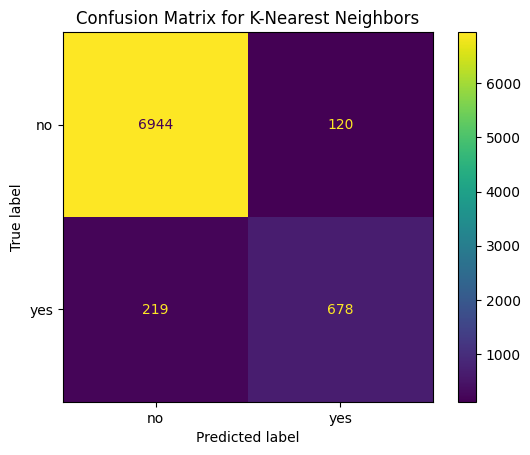

In [77]:
ConfusionMatrixDisplay.from_estimator(grid_knn.best_estimator_, X_test, y_test, values_format='d', display_labels=['no', 'yes'])
plt.title('Confusion Matrix for K-Nearest Neighbors')
plt.show()

#### Decision Tree

In [78]:
grid_dt = GridSearchCV(
    DecisionTreeClassifier(class_weight="balanced"),
    param_grid={
        "criterion": ["gini", "entropy"],
        "max_depth": [2, 3, 4, 6, 10, 15],
        "min_samples_split": range(2, 11, 4),
        "min_samples_leaf": range(1, 9, 4),
    },
    scoring="recall",
    n_jobs=4,
    # verbose=4,
).fit(X_train, y_train)

print("Best params:")
grid_dt.best_params_

Best params:


{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [79]:
grid_dt_train_preds = grid_dt.predict(X_train)
grid_dt_test_preds = grid_dt.predict(X_test)

print("Decision Tree Classifier")
print("** accuracy score:")
print(f"... on training data: {metrics.accuracy_score(y_train, grid_dt_train_preds)}")
print(f"... on test data: {metrics.accuracy_score(y_test, grid_dt_test_preds)}")
print("** precision score:")
print(f"... on training data: {metrics.precision_score(y_train, grid_dt_train_preds)}")
print(f"... on test data: {metrics.precision_score(y_test, grid_dt_test_preds)}")
print("** recall score:")
print(f"... on training data: {metrics.recall_score(y_train, grid_dt_train_preds)}")
print(f"... on test data: {metrics.recall_score(y_test, grid_dt_test_preds)}")

Decision Tree Classifier
** accuracy score:
... on training data: 0.4376609509452924
... on test data: 0.4396432608968723
** precision score:
... on training data: 0.14884222919937207
... on test data: 0.1496264254817145
** recall score:
... on training data: 0.8451253481894151
... on test data: 0.8483835005574136


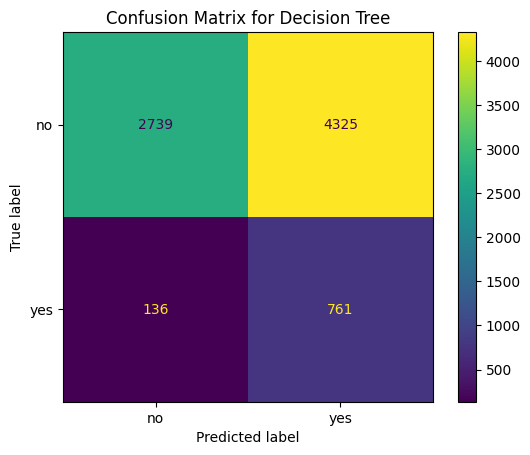

In [80]:
ConfusionMatrixDisplay.from_estimator(grid_dt.best_estimator_, X_test, y_test, values_format='d', display_labels=['no', 'yes'])
plt.title('Confusion Matrix for Decision Tree')
plt.show()

#### SVM

In [81]:
from sklearn.utils import resample

X_small, y_small = resample(X, y, random_state=42, n_samples=6000, stratify=y)
X_small = X_test.reset_index(drop = True)
y_small = y_test.reset_index(drop = True)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.2, stratify=y_small, random_state=42)

grid_svm = GridSearchCV(
    SVC(class_weight="balanced"),
    param_grid={
        "C": 10.0 ** np.array([-5, -4, -3]),
        "kernel": ["rbf", "linear", "sigmoid"],
    },
    scoring="recall",
    n_jobs=4,
    # cv=[[X_train_small.index.values, X_test_small.index.values]],
    # verbose=4,
).fit(X_train_small, y_train_small)

print("Best params:")
grid_svm.best_params_

Best params:


{'C': 0.001, 'kernel': 'sigmoid'}

In [86]:
grid_svm_train_preds = grid_svm.predict(X_train)
grid_svm_test_preds = grid_svm.predict(X_test)
grid_svm_train_small_preds = grid_svm.predict(X_train_small)
grid_svm_test_small_preds = grid_svm.predict(X_test_small)

print("SVM")
print("** accuracy score:")
print(f"... on training data: {metrics.accuracy_score(y_train, grid_svm_train_preds)}")
print(f"... on test data: {metrics.accuracy_score(y_test, grid_svm_test_preds)}")
print(f"... on small training data: {metrics.accuracy_score(y_train, grid_svm_train_preds)}")
print(f"... on small test data: {metrics.accuracy_score(y_test, grid_svm_test_preds)}")
print("** precision score:")
print(f"... on training data: {metrics.precision_score(y_train, grid_svm_train_preds)}")
print(f"... on test data: {metrics.precision_score(y_test, grid_svm_test_preds)}")
print(f"... on small training data: {metrics.precision_score(y_train, grid_svm_train_preds)}")
print(f"... on small test data: {metrics.precision_score(y_test, grid_svm_test_preds)}")
print("** recall score:")
print(f"... on training data: {metrics.recall_score(y_train, grid_svm_train_preds)}")
print(f"... on test data: {metrics.recall_score(y_test, grid_svm_test_preds)}")
print(f"... on small training data: {metrics.recall_score(y_train, grid_svm_train_preds)}")
print(f"... on small test data: {metrics.recall_score(y_test, grid_svm_test_preds)}")

SVM
** accuracy score:
... on training data: 0.48533383581433326
... on test data: 0.48260268810450946
... on small training data: 0.48533383581433326
... on small test data: 0.48260268810450946
** precision score:
... on training data: 0.1577708845865868
... on test data: 0.15650319829424306
... on small training data: 0.1577708845865868
... on small test data: 0.15650319829424306
** recall score:
... on training data: 0.8217270194986073
... on test data: 0.8182831661092531
... on small training data: 0.8217270194986073
... on small test data: 0.8182831661092531


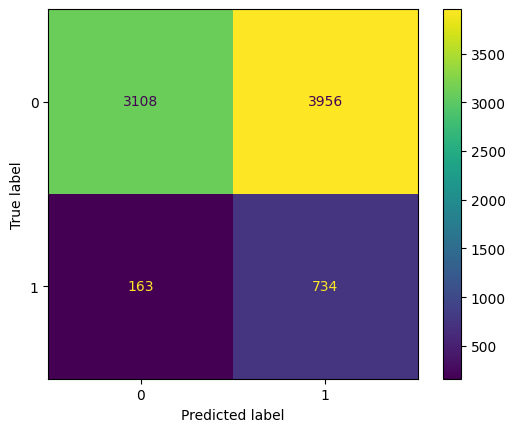

In [83]:
ConfusionMatrixDisplay.from_estimator(grid_svm, X_test, y_test, values_format='d')
plt.show()

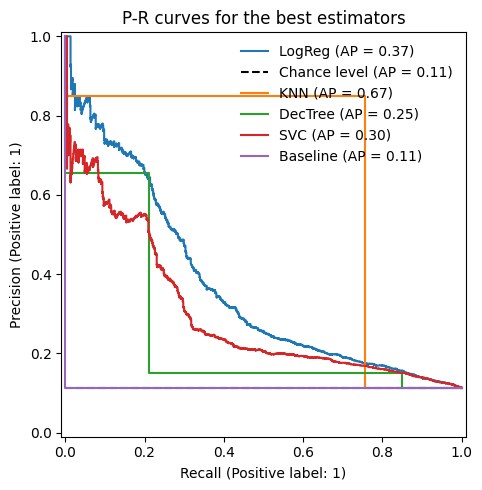

In [84]:
f, ax = plt.subplots(figsize=(5,5))

PrecisionRecallDisplay.from_estimator(grid_logreg, X_test, y_test, name='LogReg', ax = ax, plot_chance_level=True)
PrecisionRecallDisplay.from_estimator(grid_knn, X_test, y_test, name='KNN', ax = ax)
PrecisionRecallDisplay.from_estimator(grid_dt, X_test, y_test, name='DecTree', ax = ax)
PrecisionRecallDisplay.from_estimator(grid_svm, X_test, y_test, name='SVC', ax = ax)
PrecisionRecallDisplay.from_estimator(model_dummy, X_test, y_test, name='Baseline', ax = ax)

plt.title('P-R curves for the best estimators')
plt.legend(loc=1, frameon=False)

plt.tight_layout()
plt.show()

##### Findings

I have used Logistic Regression, KNN, Decision Tree, and SVM to try to model the marketing dataset. My main evaluation metric was recall due to the imbalanced target column and also to try to get a better prediction for positive outcomes (client subscribing to a term deposit). In all models, when available, I used the balanced class weight since only around 12% of the outcomes are positive.

The Logistic Regression model achieved moderate recall scores of approximately 0.646 on both training and test data, though it had low precision scores around 0.20, indicating a high number of false positives. Its accuracy was around 0.68 for both training and test sets. This suggests that while Logistic Regression was somewhat effective at identifying positive cases, it often misclassified negative cases as positive.

In contrast, the K-Nearest Neighbors (KNN) classifier showed high accuracy scores above 0.95 on both datasets and recall scores of approximately 0.75, but precision was around 0.85, which indicates a better balance between false positives and true positives compared to Logistic Regression. The Decision Tree classifier had lower accuracy (around 0.44) but high recall scores above 0.84, making it very sensitive in identifying positive cases, though with lower precision (~0.15), leading to many false positives. The SVM performed similarly to the Decision Tree with accuracy around 0.48 and recall around 0.82, maintaining consistent performance even with a smaller subset of the data. These results suggest that while KNN provided a good balance, the Decision Tree and SVM were highly effective in maximizing recall at the expense of precision and overall accuracy.